## Predictive Modeling (IS2) -Feature Subtraction From Best Model

Gradient Boosting Regression Model was found to be best for the full data set (see 04_IS2_Modeling)

In this version, feature classes or adjustments are systematically removed and best Gradient Boosting Regression Model is found for each variant.

80%/20% Train/Test split was used for each of these Feature Subtraction models, just like for Full Best Model

Note that for this version, puzzles from the first solve period (2018-2019) have been removed due to the volatility of times in that solve period. 

### High-Level Overview of 'Best Model' Modeling

Four regression models were evaluated, across the entire sample of 15x15 puzzles solved by IS2. First was simply a Linear Regression Model. The subsequent three models were decision tree models: Random Forest, Gradient Boosting Regressor and HistGradient Boosting Regressor. The latter is an ensemble machine learning algorithm that is very fast (relative to standard gradient boosting models), and performs well on heterogenous data sets. Boosting, generally, refers to a class of ensemble learning algorithms that add tree models to an ensemble sequentially. 

### Imports

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.dummy import DummyRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [12]:
os.chdir('C:/Users/jraks/Documents/GitHub/Independent-Projects/Machine-Learning-Projects/NYT-XWord_Modeling-Individual-Solver-2/notebooks')
from library.sb_utils import save_file

In [18]:
os.getcwd()

'C:\\Users\\jraks'

### Load and Filter Data

Filtering parameters identical to in dummy/simple modeling stage. 

In [19]:
# Ths is the file and analysis data range used for the main model
#Note that 2018-2019 completions were already filtered out prior to the data import here, though they were kept in to accrue retrospective stats on solver and constructor performance for puzzles 2019 and later
#df = pd.read_csv('../data/df_for_modeling.csv')
df = pd.read_csv('C:/Users/jraks/Documents/GitHub/Independent-Projects/Machine-Learning-Projects/NYT-XWord_Modeling-Individual-Solver-2/data/df_for_modeling_no_decay_weighting.csv') # for variant with decay weighting removed from all relevant features
#df = pd.read_csv('../data/df_for_modeling_no_SOS_adj.csv') # also no decay weighting
#df.head()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 50 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   P_Date                                1108 non-null   object 
 1   P_Date_str                            1108 non-null   object 
 2   IS2_Completed                         1108 non-null   float64
 3   Comp_Date                             1108 non-null   object 
 4   Comp_Date_str                         1108 non-null   object 
 5   Comp_Hr                               1108 non-null   int64  
 6   Solve_day_phase                       1108 non-null   float64
 7   IS_per_sdp_avg_past_diff_from_RPB     1108 non-null   float64
 8   DOW                                   1108 non-null   object 
 9   DOW_num                               1108 non-null   float64
 10  GMST(m)                               1108 non-null   float64
 11  IS2_ST(m)        

In [1116]:
# Drop some columns that we don't want/need for modeling (and a few would cause subtle forms of data leakage)
df_filter = df.copy()
df_filter.drop(['P_Date','P_Date_str', 'Comp_Date', 'Comp_Date_str', 'IS2_Completed','DOW', 'IS_pds_l10_ndw', 'GMST(m)', 'Constructors','overall_day_mean_IST(m)','Uniclue','Duplicate_Answers','Unchecked_Sq','Quantum'],inplace=True,axis=1)

In [1117]:
# This one has no impact on prediction quality but was raising warning in the Linear Modeling for some reason (probably all zeroes in the training set)
df_filter.drop(['Outside_Grid'], inplace=True, axis=1)

In [1118]:
#Move target feature to the front
col = df_filter.pop('IS2_ST(m)')
df_filter.insert(0, col.name, col)

In [1119]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   IS2_ST(m)                             1108 non-null   float64
 1   Comp_Hr                               1108 non-null   int64  
 2   Solve_day_phase                       1108 non-null   float64
 3   IS_per_sdp_avg_past_diff_from_RPB     1108 non-null   float64
 4   DOW_num                               1108 non-null   float64
 5   IS_pds_l10_stdev                      1108 non-null   float64
 6   IS_pds_l10_ndw_SOS_adj                1108 non-null   float64
 7   IS_per_constr_avg_past_diff_from_RPB  619 non-null    float64
 8   IS2_pds_prior_solves_ct               1108 non-null   float64
 9   IS2_npds_prior_solves_ct              1108 non-null   float64
 10  IS2_solves_l7                         1108 non-null   float64
 11  Words            

In [1120]:
#Filter out Sunday
df_filter = df_filter[df_filter["DOW_num"]!=1]

In [1030]:
#df_filter.drop(['DOW_num'],inplace=True,axis=1)

In [1031]:
# Drop feature or set of features for the particular subtraction model
#df_filter.drop(['IS_pds_l10_ndw_SOS_adj','IS_pds_l10_stdev','IS_per_constr_avg_past_diff_from_RPB', 'IS2_pds_prior_solves_ct', 'IS2_npds_prior_solves_ct', 'IS2_solves_l7'],inplace=True,axis=1) #no past performance features
#df_filter.drop(['DOW_num'],inplace=True,axis=1) #no DOW
#df_filter.drop(['Words','AWL','Blocks','Cheater_Squares','Circle_Count','Open_Squares','Shade_Count','Stacks','Unusual_Sym'],inplace=True,axis=1) #no grid features
#df_filter.drop(['Cross_Ref_Clues','Duplicate_Clues','Wordplay'],inplace=True,axis=1) #no clue features
#df_filter.drop(['Black_Square_Fill','Day_Freshness%','FITB','Freshness_Factor','Overall_Freshness%','Rebus_Unique','Rebus_Count','Scrabble_Avg','Scrabble_Illegal','Scrabble_Score','Unique_Answers','Unused_Letters'],inplace=True,axis=1) #no answer features
#df_filter.drop(['Comp_Hr','Solve_day_phase','IS_per_sdp_avg_past_diff_from_RPB'],inplace=True,axis=1) #no Circadian features
#df_filter.drop(['Comp_Hr', 'Solve_day_phase', 'IS_per_sdp_avg_past_diff_from_RPB'],inplace=True,axis=1)

In [1032]:
# Drop Past Performance feature or set of features for the particular subtraction model
#df_filter.drop(['IS_pds_l10_ndw_SOS_adj'],inplace=True,axis=1) # no RPB
#df_filter.drop(['GMS_pds_l40_dw','GMS_pds_l40_stdev','GMS_per_constr_avg_past_diff_from_RPB', 'GMS_pds_prior_solves_ct', 'GMS_npds_prior_solves_ct'],inplace=True,axis=1) #no past performance
#df_filter.drop(['IS_pds_l10_stdev'],inplace=True,axis=1)
#df_filter.drop(['GMS_pds_l40_dw', 'GMS_per_constr_avg_past_diff_from_RPB'],inplace=True,axis=1) 
#df_filter.drop(['GMS_pds_l40_dw', 'GMS_per_constr_avg_past_diff_from_RPB', 'GMS_pds_l40_stdev'],inplace=True,axis=1) 
#df_filter.drop(['IS_per_constr_avg_past_diff_from_RPB'],inplace=True,axis=1) #no constructor past performance 
#df_filter.drop(['IS2_pds_prior_solves_ct', 'IS2_npds_prior_solves_ct'],inplace=True,axis=1) #no number past solves
#df_filter.drop(['IS2_solves_l7'],inplace=True,axis=1) #no number past solves

In [1121]:
# Drop individual features from class other than Past Performance, or part/whole of class
#df_filter.drop(['Black_Square_Fill','Day_Freshness%','FITB','Freshness_Factor','Outside_Grid','Overall_Freshness%','Rebus_Unique','Rebus_Count','Scrabble_Avg','Scrabble_Illegal','Scrabble_Score','Unique_Answers','Unused_Letters'],inplace=True,axis=1) #no answer features
#df_filter.drop(['Day_Freshness%','Freshness_Factor','Overall_Freshness%'],inplace=True,axis=1) #Freshness Factor features
#df_filter.drop(['Unique_Answers'],inplace=True,axis=1) 
df_filter.drop(['Scrabble_Avg'],inplace=True,axis=1) 
#df_filter.drop(['Scrabble_Illegal'],inplace=True,axis=1)
#df_filter.drop(['Black_Square_Fill'],inplace=True,axis=1)
#df_filter.drop(['FITB'],inplace=True,axis=1)
#df_filter.drop(['Outside_Grid'],inplace=True,axis=1)
#df_filter.drop(['Rebus_Unique','Rebus_Count'],inplace=True,axis=1)
#df_filter.drop(['Scrabble_Score'],inplace=True,axis=1)
#df_filter.drop(['Unused_Letters'],inplace=True,axis=1)
#df_filter.drop(['Wordplay'],inplace=True,axis=1)
#df_filter.drop(['AWL'],inplace=True,axis=1)
#df_filter.drop(['Blocks'],inplace=True,axis=1)
#df_filter.drop(['Cheater_Squares'],inplace=True,axis=1)
#df_filter.drop(['Circle_Count'],inplace=True,axis=1)
#df_filter.drop(['Open_Squares'],inplace=True,axis=1)
#df_filter.drop(['Shade_Count'],inplace=True,axis=1)
#df_filter.drop(['Stacks'],inplace=True,axis=1)
#df_filter.drop(['Unusual_Sym'],inplace=True,axis=1)
#df_filter.drop(['Cross_Ref_Clues'],inplace=True,axis=1)
#df_filter.drop(['Words'],inplace=True,axis=1)
#df_filter.drop(['IS1_solves_l7'],inplace=True,axis=1)
#df_filter.drop(['Comp_Hr'],inplace=True,axis=1)

In [1034]:
#df_filter.drop(['AWL'],inplace=True,axis=1) 

In [1122]:
#Deep copy of this df_filter that is now pared down to just the predictive features and the target feature itself 
# All features are derived from data available prior to any given puzzle being predicted on. No data leakage!
df_model1 = df_filter.copy()

#df_model1 = df_model1[['IS1_ST(m)', 'Comp_Hr', 'Solve_day_phase', 'IS_per_sdp_avg_past_diff_from_RPB', 'DOW_num', 'IS_pds_l10_dw', 'IS_pds_l10_stdev', 'IS_per_constr_avg_past_diff_from_RPB', 'IS1_pds_prior_solves_ct', 'IS1_npds_prior_solves_ct', 'num_solves_l7', 'Words', 'Blocks', 'Unused_Letters', 'Stacks','Unique_Answers','Rebus_Count','Rebus_Unique','Cheater_Squares','AWL','Scrabble_Score','Scrabble_Avg','FITB','Cross_Ref_Clues','Scrabble_Illegal','Open_Squares','Freshness_Factor','Overall_Freshness%','Day_Freshness%','Duplicate_Clues','Circle_Count','Shade_Count','Unusual_Sym','Black_Square_Fill','Outside_Grid','Wordplay']]

#df_model1.drop(['IS_per_constr_avg_past_diff_from_RPB','Scrabble_Score', 'IS_pds_l10_dw', 'IS_pds_l10_stdev'],inplace=True,axis=1)

In [1123]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 956 entries, 0 to 1107
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   IS2_ST(m)                             956 non-null    float64
 1   Comp_Hr                               956 non-null    int64  
 2   Solve_day_phase                       956 non-null    float64
 3   IS_per_sdp_avg_past_diff_from_RPB     956 non-null    float64
 4   DOW_num                               956 non-null    float64
 5   IS_pds_l10_stdev                      956 non-null    float64
 6   IS_pds_l10_ndw_SOS_adj                956 non-null    float64
 7   IS_per_constr_avg_past_diff_from_RPB  532 non-null    float64
 8   IS2_pds_prior_solves_ct               956 non-null    float64
 9   IS2_npds_prior_solves_ct              956 non-null    float64
 10  IS2_solves_l7                         956 non-null    float64
 11  Words             

In [918]:
#df_model1.to_csv('../data/df_model1.csv', index=False)

### Data Split for Modeling

Identical split as for dummy/simple modeling

In [1124]:
len(df_model1) * .80, len(df_model1) * .20

(764.8000000000001, 191.20000000000002)

In [1125]:
#Replicates EXACT train-test split from dummy and simpler modeling
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='IS2_ST(m)'), 
                                                    df_model1['IS2_ST(m)'], test_size=0.20, 
                                                    random_state=47)

In [1126]:
y_train.shape, y_test.shape

((764,), (192,))

In [1127]:
y_train

888     12.016667
337     14.350000
140     10.200000
39      14.633333
274      9.500000
          ...    
682     18.283333
307     23.583333
379     21.000000
1045    16.533333
157     47.733333
Name: IS2_ST(m), Length: 764, dtype: float64

In [1128]:
X_train.shape, X_test.shape

((764, 33), (192, 33))

In [1129]:
# Get training set mean to normalize the error to, as this will change with different puzzle day subtractions
#Target feature (IST(m)) training set mean
train_mean = y_train.mean()
train_mean

18.116513961605584

## Gradient Boosting Regression Model

### Gradient Boosting Model: Hyperparameter Grid Search

In [1130]:
#Define pipeline 
GB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    GradientBoostingRegressor(random_state= 47)
)

In [1131]:
GB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'gradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estim

In [1137]:
# #Define Grid Parameters
n_est = [130] 
learning_rate = [.03] 
max_depth = [5,6,7] 
max_features = [9,10,11] 
subsamples = [0.6] 

grid_params = {
        'gradientboostingregressor__n_estimators': n_est,
        'standardscaler': [None],
        'simpleimputer__strategy': ['mean', 'median'],
        'gradientboostingregressor__learning_rate': learning_rate,
        'gradientboostingregressor__max_depth': max_depth,
        'gradientboostingregressor__max_features': max_features,
        'gradientboostingregressor__subsample': subsamples
}
grid_params

{'gradientboostingregressor__n_estimators': [130],
 'standardscaler': [None],
 'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingregressor__learning_rate': [0.03],
 'gradientboostingregressor__max_depth': [5, 6, 7],
 'gradientboostingregressor__max_features': [9, 10, 11],
 'gradientboostingregressor__subsample': [0.6]}

In [1138]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
gb_grid_cv = GridSearchCV(GB_pipe, param_grid=grid_params, cv=5)

In [1139]:
# #Define Grid Parameters
# n_est = [125, 130, 135] 130
# learning_rate = [.02, .03, .04] .03
# max_depth = [3,4,5] 5
# max_features = [7,8,9] 9
# subsamples = [0.5,0.6,0.7] 0.6

# grid_params = {
#         'gradientboostingregressor__n_estimators': n_est,
#         'standardscaler': [None],
#         'simpleimputer__strategy': ['mean', 'median'],
#         'gradientboostingregressor__learning_rate': learning_rate,
#         'gradientboostingregressor__max_depth': max_depth,
#         'gradientboostingregressor__max_features': max_features,
#         'gradientboostingregressor__subsample': subsamples
# }
# grid_params


# {'gradientboostingregressor__n_estimators': [125, 130, 135],
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['mean', 'median'],
#  'gradientboostingregressor__learning_rate': [0.02, 0.03, 0.04],
#  'gradientboostingregressor__max_depth': [3, 4, 5],
#  'gradientboostingregressor__max_features': [7, 8, 9],
#  'gradientboostingregressor__subsample': [0.5, 0.6, 0.7]}

In [1140]:
#Call `GridSearchCV` with the gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
gb_grid_cv = GridSearchCV(GB_pipe, param_grid=grid_params, cv=5)

In [1141]:
#conduct the grid search. 
gb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=47))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.03],
                         'gradientboostingregressor__max_depth': [5, 6, 7],
                         'gradientboostingregressor__max_features': [9, 10, 11],
                         'gradientboostingregressor__n_estimators': [130],
                         'gradientboostingregressor__subsample': [0.6],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [None]})

In [1142]:
#Best params (`best_params_` attribute) from the grid search
gb_grid_cv.best_params_

{'gradientboostingregressor__learning_rate': 0.03,
 'gradientboostingregressor__max_depth': 5,
 'gradientboostingregressor__max_features': 9,
 'gradientboostingregressor__n_estimators': 130,
 'gradientboostingregressor__subsample': 0.6,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

### Best Gradient Boosting Model Performance Metrics

#### R-squared (COD)

In [1143]:
#Cross-validation defaults to R^2 metric for scoring regression
gb_best_cv_results = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, cv=5)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

array([0.6318049 , 0.62479287, 0.55005566, 0.68350723, 0.59554911])

In [1144]:
#Training set CV mean and std
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.6171419536617851, 0.043919720071917696)

#### Mean Absolute Error (MAE)

In [1145]:
gb_neg_mae = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [1146]:
#Training set CV mean and std
gb_mae_mean = np.mean(-1 * gb_neg_mae['test_score'])
gb_mae_std = np.std(-1 * gb_neg_mae['test_score'])
gb_mae_mean, gb_mae_std

(5.258358181090969, 0.40462670887880653)

In [1147]:
# Test set mean
mean_absolute_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

7.333621752180519

#### Mean Squared Error (MSE)

In [1148]:
gb_neg_mse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [1149]:
#Training set CV mean and std
gb_mse_mean = np.mean(-1 * gb_neg_mse['test_score'])
gb_mse_std = np.std(-1 * gb_neg_mse['test_score'])
gb_mse_mean, gb_mse_std

(63.596891231093046, 6.6219996068847715)

In [1150]:
# Test set mean
mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

162.29808919539835

#### Root Mean Square Error (RMSE)

In [1151]:
gb_neg_rmse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [1152]:
#Training set CV mean and std
gb_rmse_mean = np.mean(-1 * gb_neg_rmse['test_score'])
gb_rmse_std = np.std(-1 * gb_neg_rmse['test_score'])
gb_rmse_mean, gb_rmse_std

(7.9641375292366465, 0.41158795718223884)

In [1153]:
# Test set mean
np.sqrt(mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test)))

12.739626729045021

### Best Gradient Boosting Model Feature Performance

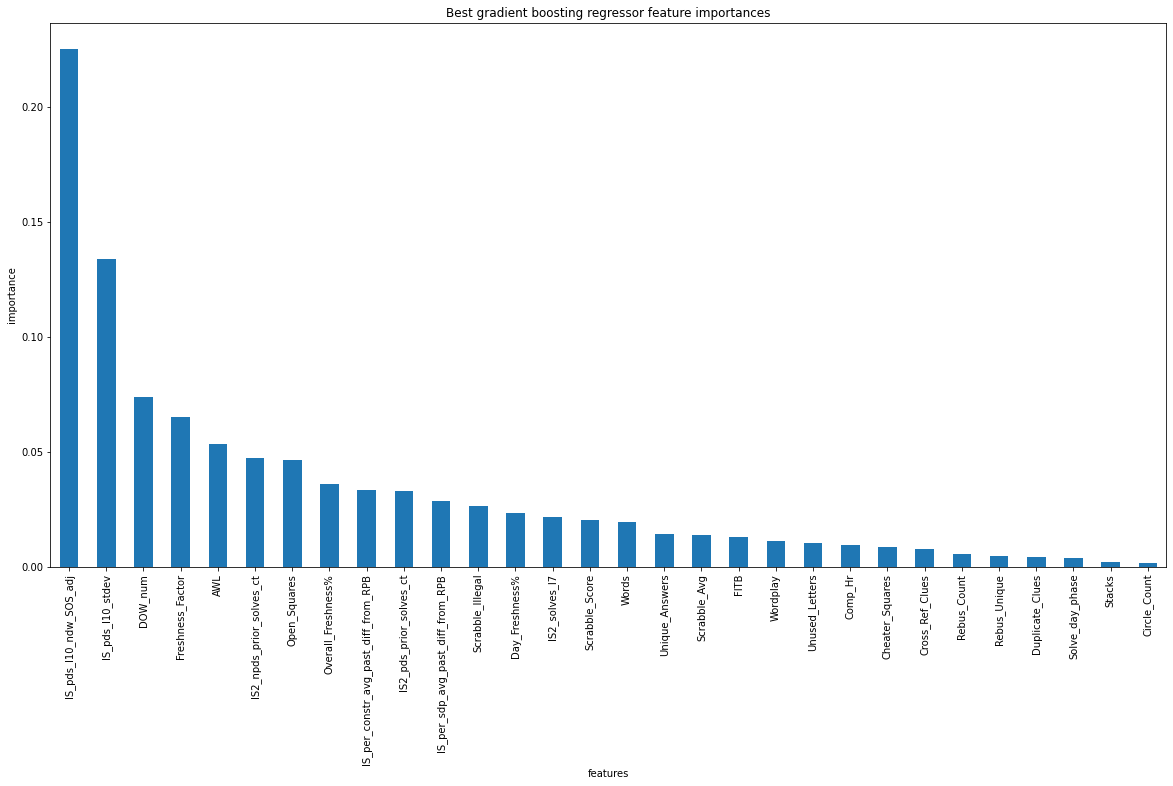

In [1115]:
#Plot a barplot of the gradient boosting model's feature importances,
#assigning the `feature_importances_` attribute of 
#`gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor.feature_importances_
gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
gb_feat_imps.nlargest(30).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting regressor feature importances');

In [351]:
# Export out features and feature importances for full documentation csv
X_train.columns
gb_feat_imps.to_csv('../data/gb_feat_imps.csv', index=True)

FileNotFoundError: [Errno 2] No such file or directory: '../data/gb_feat_imps.csv'

## Save Best Model Object From Pipeline

In [305]:
best_model = gb_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [306]:
# save the model
modelpath = '../models'
save_file(best_model, 'IS1_no_SOS_adj_gb.pkl', modelpath)

Writing file.  "../models\IS1_no_SOS_adj_lr.pkl"


### Data Quality Assessment

Because Gradient Boosting Regressor turned out to be the best of the four models tested (in terms of cross-validation RMSE), a Data Quality Assessment was run on this model to ensure that results are not hindered by sample size. 

In [307]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(GB_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


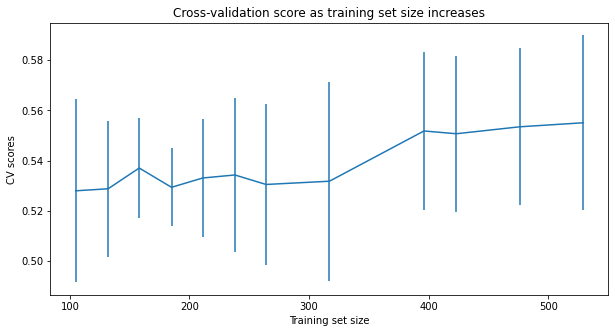

In [308]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');